# Predictive Maintenance Workshop

This notebook is an educational walkthrough that uses the feature extraction and pipeline functions in `Preparation/Sample Preparation/Feature_extraction_pipeline` to:

1. Load and inspect audio files
2. Visualize waveforms and spectrograms
3. Extract features (MFCC + simple statistics)
4. Prepare data and train multiple models
5. Compare model performance and run inference on new audio files

Run cells sequentially. If you are missing optional packages (librosa, ipywidgets), install them first.

In [17]:
# Basic imports and configuration
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

sns.set_theme(style="whitegrid")
np.random.seed(42)

# Add local feature-extraction package to path so we can import our functions
sys.path.append(str(Path('./Preparation/Sample Preparation/Feature_extraction_pipeline').resolve()))

# Import the functions implemented in the repository
from loader import load_long_audio
from splitters import segment_train_test
from features_extractor import extract_mfcc_features, extract_features_for_list
from orchestrator import run_pipeline_on_dataset, run_pipeline_on_file
# rich_features is optional and lazily loaded by upstream orchestrator code in the repo

print('Imports OK')

# --- Pipeline parameter cell will be right below; edit it to change behavior for the whole notebook ---


Imports OK


In [18]:
# Populate `df` with audio files found under data/audio and set `data_dir`
data_dir = Path("data/audio")
_allowed_exts = {".wav", ".flac", ".mp3", ".m4a", ".ogg"}

if not data_dir.exists():
    raise SystemExit(f"Data directory not found: {data_dir}. Create it and place audio files under subfolders per-class (e.g. data/audio/<label>/*.wav)")

_records = []
for f in sorted(data_dir.rglob("*")):
    if f.is_file() and f.suffix.lower() in _allowed_exts:
        _records.append({"file_path": f, "label": f.parent.name})

df = pd.DataFrame(_records)

if df.empty:
    raise SystemExit(f"No audio files found under {data_dir}. Use extensions: {_allowed_exts}")

print(f"Found {len(df)} audio files under {data_dir}")
display(df.head())

Found 4 audio files under data/audio


file_path          label
0  data/audio/Chipped Tooth/20250930_170743.wav  Chipped Tooth
1  data/audio/Chipped Tooth/20250930_171840.wav  Chipped Tooth
2           data/audio/Good/20250930_163202.wav           Good
3           data/audio/Good/20250930_164401.wav           Good

File: data/audio/Chipped Tooth/20250930_170743.wav  Label: Chipped Tooth
Duration: 600.00 s, SR: 40000 Hz


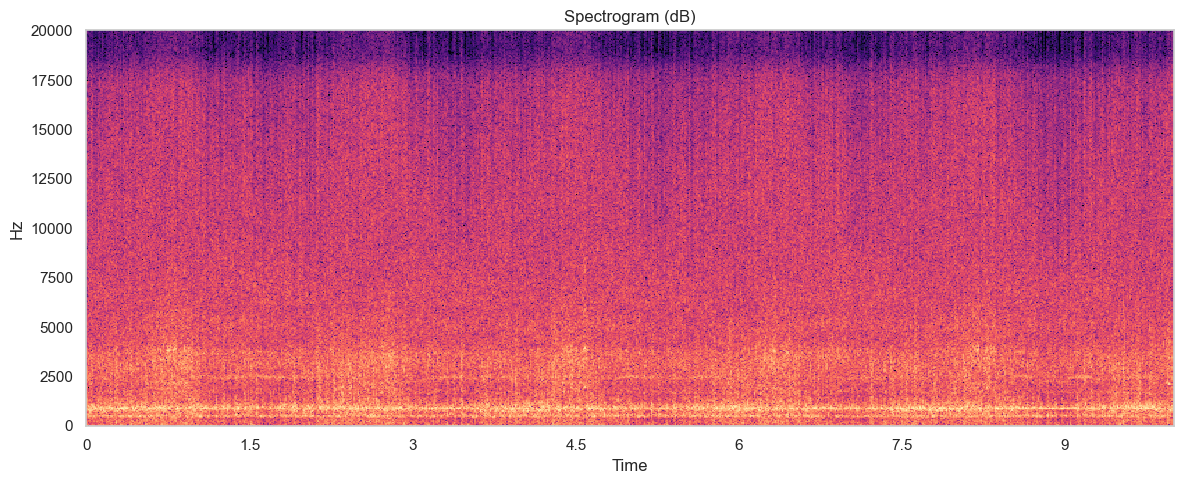

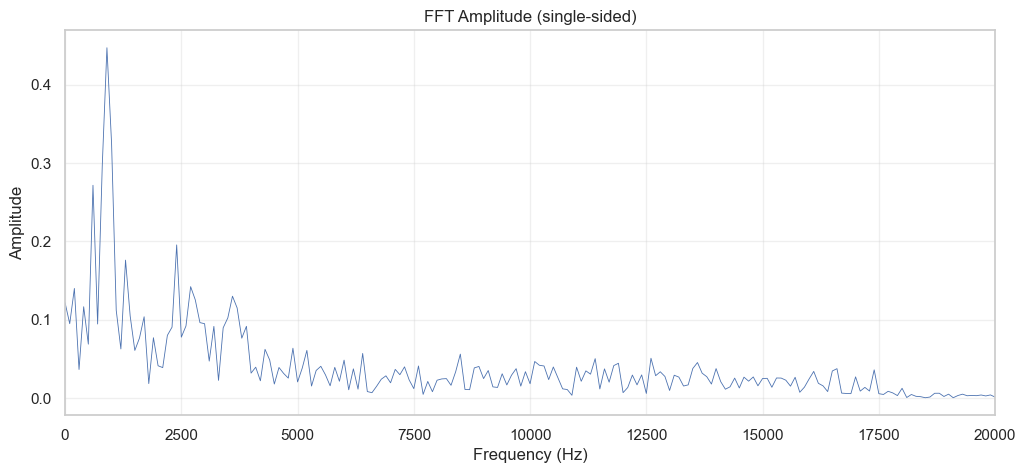

In [19]:
# Pick a sample index (change to explore other files)
if len(df) == 0:
    raise SystemExit('No audio files found in data_dir; please update the path or add samples.')

sample_idx = 0
sample_file = df.iloc[sample_idx]['file_path']
sample_label = df.iloc[sample_idx]['label']

# Load audio using the repo loader (returns mono 1-D numpy array and sr)
audio_data, sr = load_long_audio(sample_file)
print(f'File: {sample_file}  Label: {sample_label}')
print(f'Duration: {len(audio_data)/sr:.2f} s, SR: {sr} Hz')

# Play audio (small files)
#display(Audio(data=audio_data, rate=sr))
audio_data=audio_data[:sr*10]  # limit to first 10 seconds for playback
display(Audio(data=audio_data, rate=sr))
# Plot waveform + spectrogram
import librosa
import librosa.display


# Spectrogram (log amplitude)
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))
S = np.abs(librosa.stft(audio_data, n_fft=1024, hop_length=512))
S_db = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', ax=ax1)
# set title on the Axes object (plt.set_title does not exist)
ax1.set_title('Spectrogram (dB)')
plt.tight_layout()
plt.show()

# Compute single-sided FFT amplitude for the current audio_data (linear amplitude)
N = len(audio_data[:400])
yf = np.fft.rfft(audio_data[:400])
freqs = np.fft.rfftfreq(N, 1.0 / sr)

# Single-sided amplitude scaling
mag = np.abs(yf) / N
if mag.size > 2:
    mag[1:-1] *= 2.0

# Plot amplitude spectrum
plt.figure(figsize=(12, 5))
plt.plot(freqs, mag, linewidth=0.6)
plt.xlim(0, sr / 2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Amplitude (single-sided)')
plt.grid(alpha=0.3)
plt.show()



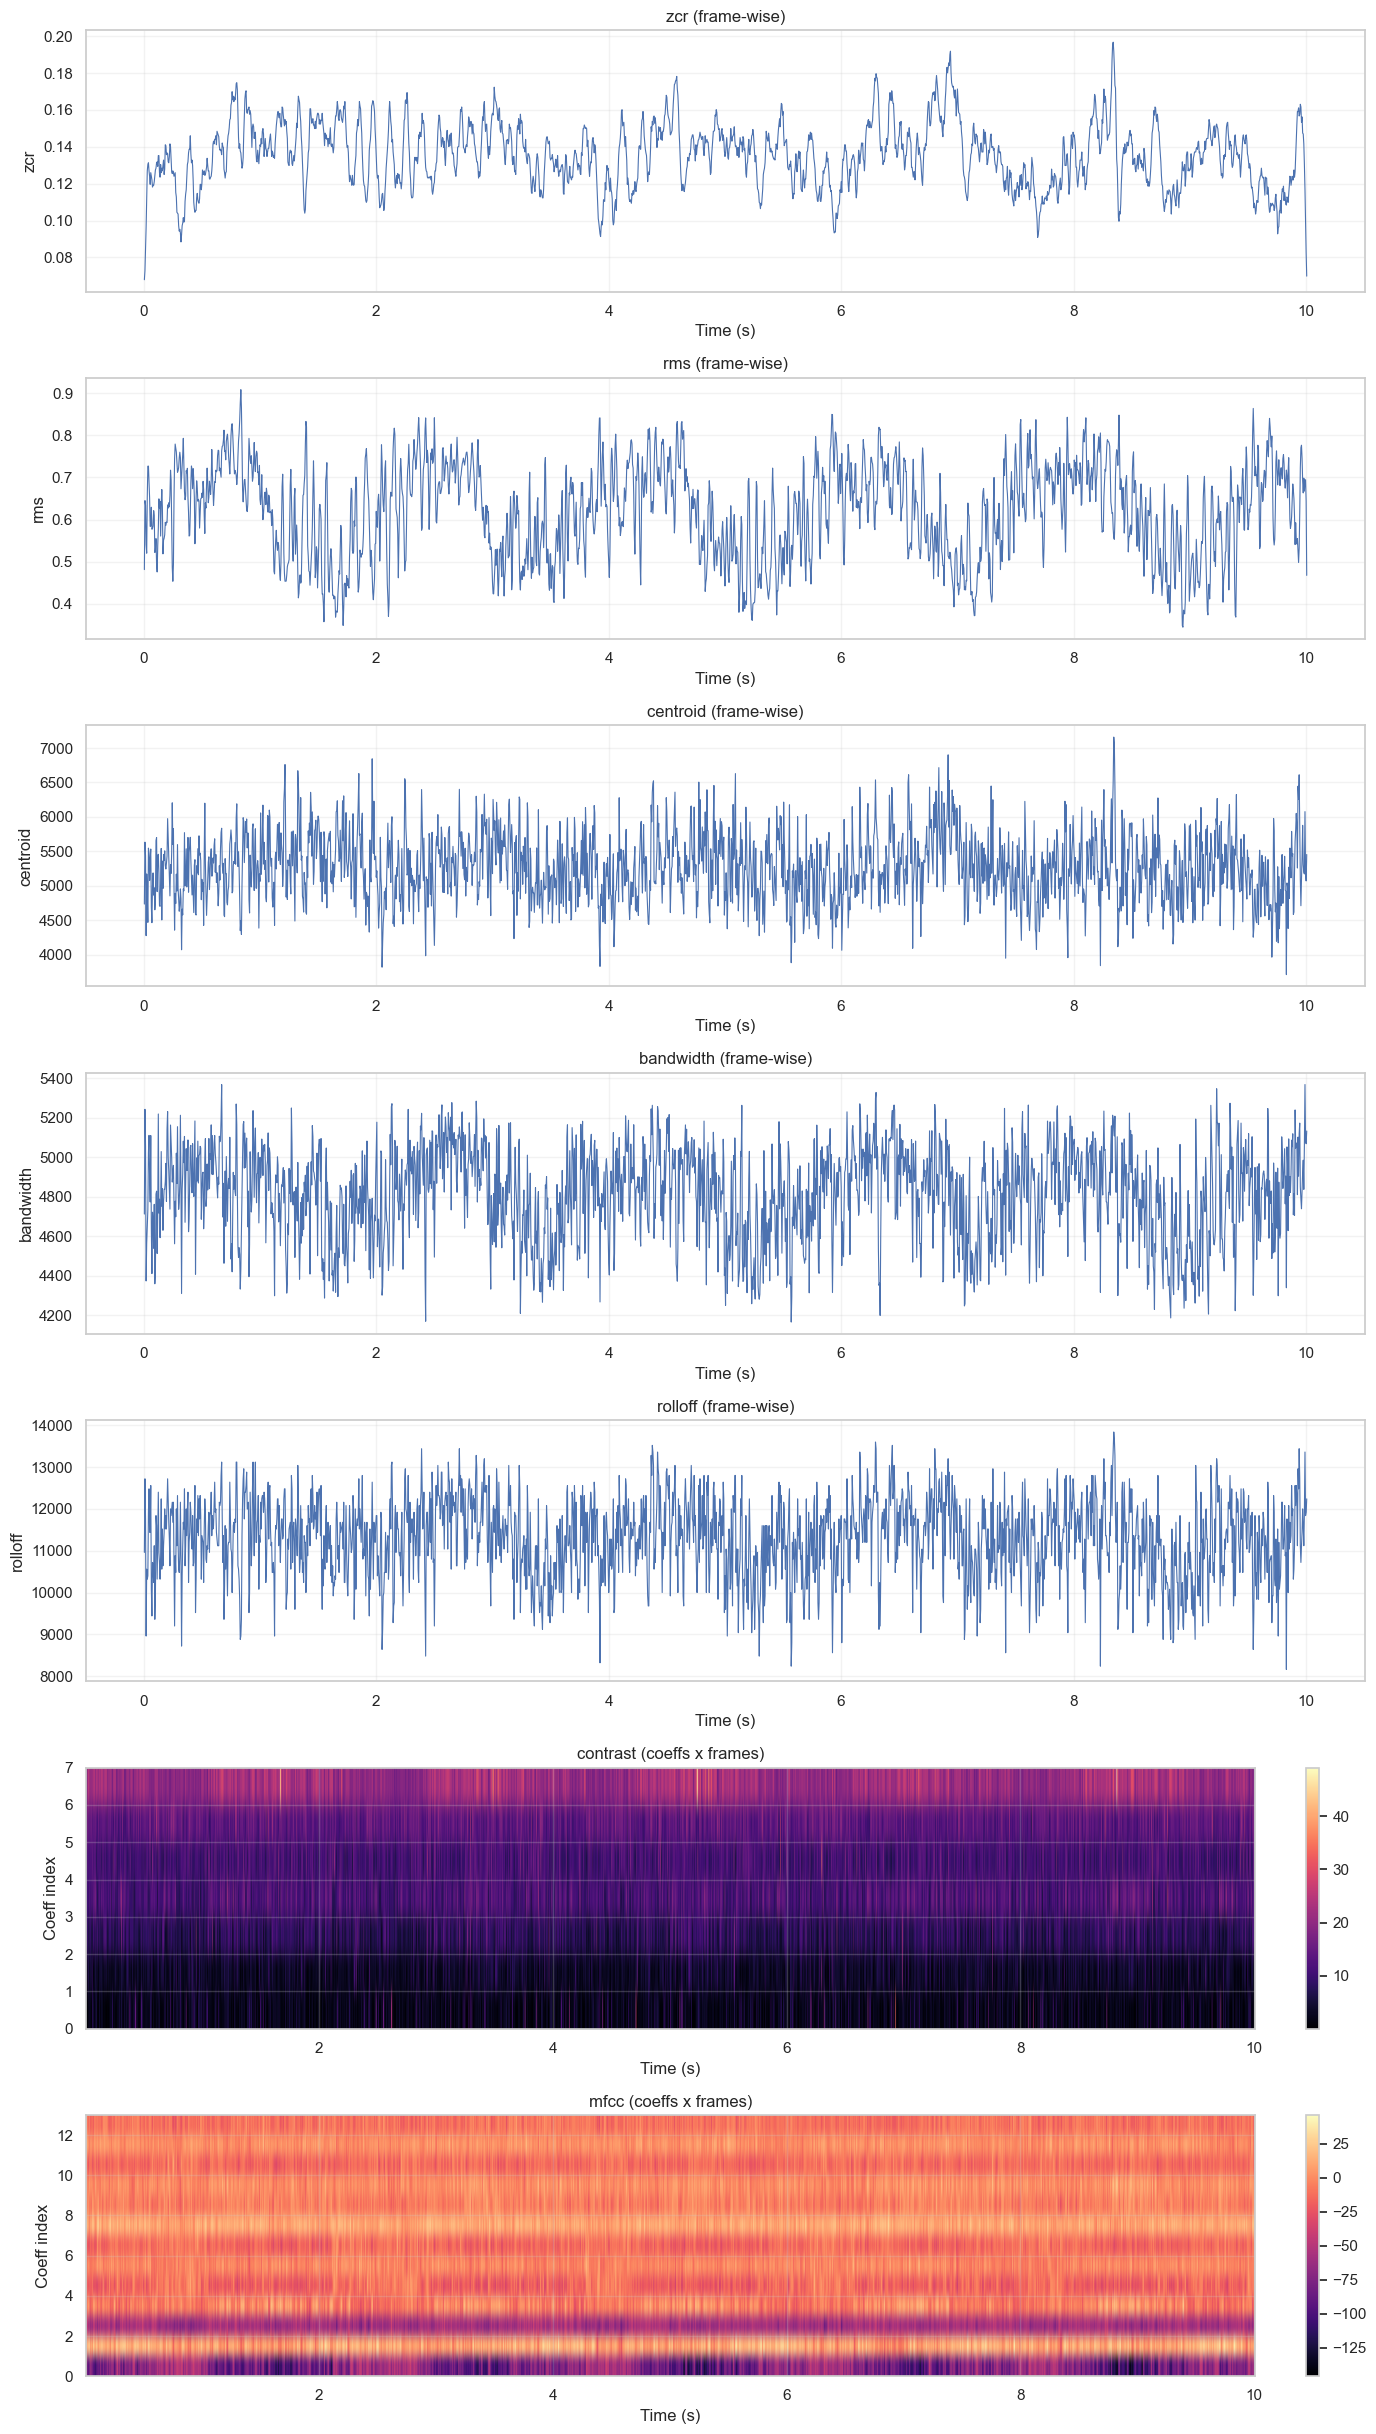

In [20]:
# ---- Representative plots for "rich" features ----
# If a rich_features object exists in the notebook, use it; otherwise compute a set of common features
hop_length = 200
n_fft = 500


rf = {}
y = audio_data
# common framewise features
rf['zcr'] = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)[0]
rf['rms'] = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)[0]
rf['centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
rf['bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
rf['rolloff'] = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
rf['contrast'] = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
rf['mfcc'] = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# time axis for frame-based features (fallback to STFT frame count)
def frames_time(length):
    if length <= 1:
        return np.array([0.0])
    return librosa.frames_to_time(np.arange(length), sr=sr, hop_length=hop_length, n_fft=n_fft)

# Prepare plotting grid
feat_items = list(rf.items())
n_feats = len(feat_items)
cols = 1
rows = int(np.ceil(n_feats / cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, 3.5 * rows), squeeze=False)
for i, (name, arr) in enumerate(feat_items):
    ax = axes[i // cols][i % cols]
    arr = np.asarray(arr)
    # 1D: simple time series
    if arr.ndim == 1:
        t = frames_time(arr.shape[0])
        ax.plot(t, arr, linewidth=0.8)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel(name)
        ax.set_title(f'{name} (frame-wise)')
    # 2D: show as heatmap (coeffs x frames)
    elif arr.ndim == 2:
        frames = arr.shape[1]
        t = frames_time(frames)
        extent = [t[0], t[-1] if len(t)>0 else 0, 0, arr.shape[0]]
        im = ax.imshow(arr, aspect='auto', origin='lower', extent=extent, cmap='magma')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Coeff index')
        ax.set_title(f'{name} (coeffs x frames)')
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    else:
        ax.text(0.5, 0.5, f'Unsupported shape {arr.shape}', ha='center', va='center')
    ax.grid(alpha=0.25)

# Hide any unused axes
for j in range(n_feats, rows * cols):
    axes[j // cols][j % cols].axis('off')

plt.tight_layout()
plt.show()

## 3) Feature extraction (MFCC demo)

We'll segment the audio into 1-second windows (50% overlap) and compute MFCC means + delta means for each segment using `extract_features_for_list`. This is the lightweight extractor present in the repo.

Produced 14 train-style segments from the sample file
Features shape: (10, 26)


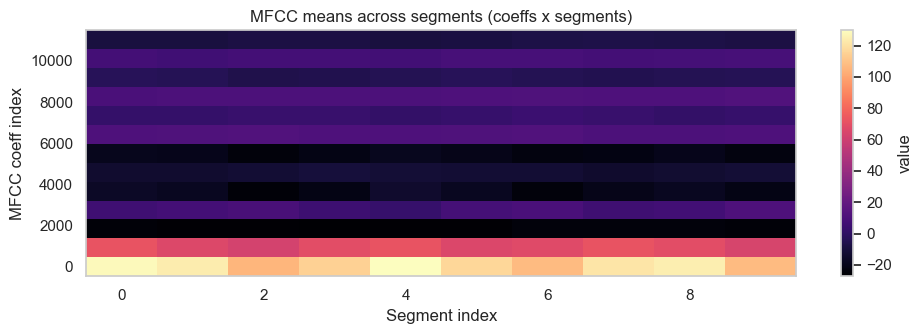

In [21]:
# Segment audio into 1s windows (train-style segmentation)
segments = segment_train_test(audio_data, sr, segment_seconds=1.0, overlap=0.5)
train_segments = segments['train']
print(f'Produced {len(train_segments)} train-style segments from the sample file')

# Extract MFCC-based features for the first few segments
X_sample, feature_names = extract_features_for_list(train_segments[:10], sr)
print('Features shape:', X_sample.shape)

# Improved visualization using librosa (shows MFCC means + delta means)
n_mfcc = X_sample.shape[1] // 2
mfcc_means = X_sample[:, :n_mfcc]
mfcc_deltas = X_sample[:, n_mfcc:]

num = min(3, X_sample.shape[0])

# Heatmap of MFCC means across segments (coeffs x segments)
plt.figure(figsize=(10, 3.5))
librosa.display.specshow(mfcc_means.T, x_axis='frames', y_axis='linear', cmap='magma')
plt.xlabel('Segment index')
plt.ylabel('MFCC coeff index')
plt.title('MFCC means across segments (coeffs x segments)')
plt.colorbar(label='value')
plt.tight_layout()
plt.show()



## 4) Prepare dataset for training

We'll extract features for all files, stack them into X and build y labels. Then we'll split and scale the data.

In [22]:
# Pipeline parameters (edit to change behavior for the whole notebook)
# src_dir: dataset root (expects subfolders per-class)
src_dir = data_dir  # reuse data_dir defined earlier (Path)

# Segmentation / splitting parameters
segment_seconds = 0.2   # length of segments in seconds
overlap = 0            # fraction overlap between segments (0.0 - 1.0)
train_fraction = 0.8     # fraction of data/time used for training per-file splitting
buffer_seconds = 0.0     # seconds to exclude from file boundaries when splitting

# Feature extraction level understood by the orchestrator (common values: 'segment', 'file', etc.)
feature_level = "basic"  #choose from "raw", "basic", "standard", "advanced"

print("Pipeline parameters set:",
    dict(src_dir=src_dir, segment_seconds=segment_seconds, overlap=overlap,
         train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level))

Pipeline parameters set: {'src_dir': PosixPath('data/audio'), 'segment_seconds': 0.2, 'overlap': 0, 'train_fraction': 0.8, 'buffer_seconds': 0.0, 'feature_level': 'basic'}


### 📊 Feature Extraction Levels

The pipeline supports four different levels of feature extraction:

- **`raw`** - Returns binned raw audio samples (max 10,000 features)
  - Best for: Deep learning models that need raw audio but with manageable dimensionality
  - Output: Binned waveform samples (e.g., 10,000 features for 5-second segments)
  - Method: Groups consecutive samples and takes their mean to reduce from 200k→10k features
  - Benefits: Preserves temporal structure while keeping memory/computation reasonable

- **`basic`** - Simple time-domain statistics
  - Best for: Quick analysis, low-complexity models
  - Features: Mean, std, RMS, zero-crossing rate, quantiles, energy, etc.
  - Output: ~15 features per segment

- **`standard`** - Comprehensive audio features (recommended)
  - Best for: Most predictive maintenance applications
  - Features: Basic stats + MFCC + spectral features + chroma + tempo
  - Output: ~60-80 features per segment

- **`advanced`** - Advanced time-series and signal processing features
  - Best for: Complex fault detection requiring sophisticated analysis
  - Features: Standard + Hjorth parameters + entropy measures + spectral entropy
  - Output: ~90-100 features per segment

Choose based on your model complexity, computational resources, and performance requirements.

In [23]:
# Use run_pipeline_on_dataset to extract features per file and respect the orchestrator's train/test splitting

# 🛠️ Force reload to ensure dataset pipeline uses the fixed orchestrator
from orchestrator import run_pipeline_on_dataset

def build_dataset_with_orchestrator(src_dir: Path, segment_seconds=segment_seconds, overlap=overlap, train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level):
    """Run the orchestrator over the dataset directory and return stacked train/test datasets.

    Defaults reference the top-level variables so changing them above changes the whole notebook.
    """
    result = run_pipeline_on_dataset(src_dir, segment_seconds=segment_seconds, overlap=overlap, train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level)
    X_train = result['train']['X']
    y_train = np.array(result['train']['y'])
    X_test = result['test']['X']
    y_test = np.array(result['test']['y'])
    return X_train, y_train, X_test, y_test, result

# Run orchestrator on the dataset directory (this will segment per-file and extract richer features when available)
print('Running pipeline on dataset with parameters:', dict(segment_seconds=segment_seconds, overlap=overlap, train_fraction=train_fraction, buffer_seconds=buffer_seconds, feature_level=feature_level))
X_train, y_train, X_test, y_test, pipeline_result = build_dataset_with_orchestrator(data_dir)
print('Train X shape:', X_train.shape, 'Test X shape:', X_test.shape)
feature_names = pipeline_result.get('feature_names', [])

Running pipeline on dataset with parameters: {'segment_seconds': 0.2, 'overlap': 0, 'train_fraction': 0.8, 'buffer_seconds': 0.0, 'feature_level': 'basic'}
Train X shape: (7200, 14) Test X shape: (1800, 14)


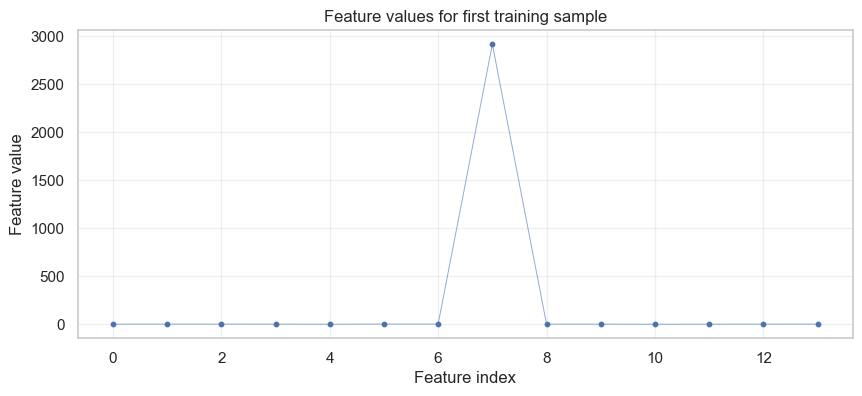

In [24]:
# Scatter plot of first training sample: feature index vs value
x = np.arange(X_train.shape[1])
y = X_train[0]
plt.figure(figsize=(10, 4))
plt.scatter(x, y, s=10)
plt.plot(x, y, linewidth=0.7, alpha=0.6)
plt.xlabel('Feature index')
plt.ylabel('Feature value')
plt.title('Feature values for first training sample')
plt.grid(alpha=0.3)
plt.show()

In [25]:
# No manual train/test split here — the orchestrator already produced time-contiguous splits per file
from sklearn.preprocessing import StandardScaler

if X_train.size == 0 and X_test.size == 0:
    raise SystemExit('No features extracted — check the dataset and feature extractor')

scaler = StandardScaler()
if X_train.size:
    X_train_scaled = scaler.fit_transform(X_train)
else:
    X_train_scaled = X_train
if X_test.size:
    X_test_scaled = scaler.transform(X_test)
else:
    X_test_scaled = X_test

print('Train shape:', X_train_scaled.shape, 'Test shape:', X_test_scaled.shape)


Train shape: (7200, 14) Test shape: (1800, 14)


## 5) Train models and evaluate

We'll train three models: RandomForest, SVM, and a small MLP. For speed in a teaching environment, defaults are modest.

In [26]:
from sklearn.model_selection import StratifiedKFold, cross_val_score,TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# CV parameters
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#cv=TimeSeriesSplit(n_splits=n_splits)

# models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, verbose=0),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv):
    # cross-validation may fail if classes are not suitable for StratifiedKFold; catch errors to avoid crashing the cell
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        if cv_scores.size:
            print(f'  CV acc: mean={cv_scores.mean():.4f} std={cv_scores.std():.4f}  (n_splits={n_splits})')
    except Exception as e:
        print(f'  Warning: CV failed for {name}: {e}')
        cv_scores = np.array([])

    model.fit(X_train, y_train)
    try:
        y_pred = model.predict(X_test)
    except Exception as e:
        print(f"Warning: could not predict with {name}: {e}")
        acc = float('nan')
        report = ''
        conf = None
    else:
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf = confusion_matrix(y_test, y_pred)
        print(f'  Test acc: {acc:.4f}')
    return {
        'cv_scores': cv_scores,
        'model': model,
        'accuracy': acc,
        'report': report,
        'confusion': conf
    }

# Evaluate models
results = {}
results['Logistic Regression']= evaluate_model('Logistic Regression', models['Logistic Regression'], X_train_scaled, y_train, X_test_scaled, y_test, cv)
results['Random Forest'] = evaluate_model('Random Forest', models['Random Forest'], X_train_scaled, y_train, X_test_scaled, y_test, cv)
results['SVM'] = evaluate_model('SVM', models['SVM'], X_train_scaled, y_train, X_test_scaled, y_test, cv)
results['MLP'] = evaluate_model('MLP', models['MLP'], X_train_scaled, y_train, X_test_scaled, y_test, cv)

# Summary
print('\nSummary (CV mean acc  |  Test acc):')
for name, r in results.items():
    cv_mean = float(np.mean(r['cv_scores'])) if 'cv_scores' in r and r['cv_scores'].size else np.nan
    print(f"{name:15s} -> CV: {cv_mean:.4f}  |  Test: {r['accuracy']:.4f}")

  CV acc: mean=0.9976 std=0.0008  (n_splits=5)
  Test acc: 0.9978
  CV acc: mean=0.9969 std=0.0008  (n_splits=5)
  Test acc: 0.9983
  CV acc: mean=0.9971 std=0.0008  (n_splits=5)
  Test acc: 0.9983
  CV acc: mean=0.9975 std=0.0008  (n_splits=5)
  Test acc: 0.9983

Summary (CV mean acc  |  Test acc):
Logistic Regression -> CV: 0.9976  |  Test: 0.9978
Random Forest   -> CV: 0.9969  |  Test: 0.9983
SVM             -> CV: 0.9971  |  Test: 0.9983
MLP             -> CV: 0.9975  |  Test: 0.9983


In [27]:
# select the trained model with highest recorded accuracy in `results`
best_name, best_info = max(results.items(), key=lambda kv: kv[1]['accuracy'])
best_model = best_info['model']
acc = float(best_info.get('accuracy', np.nan))

# update y_pred_best using the selected model (uses X_test_scaled from notebook)
try:
    y_pred_best = best_model.predict(X_test_scaled)
except Exception as e:
    # if prediction fails, keep previous y_pred_best if present and warn
    print(f"Warning: could not predict with selected model {best_name}: {e}")
else:
    print(f"Selected best model: {best_name} (accuracy={acc:.4f})")

Selected best model: Random Forest (accuracy=0.9983)


In [ ]:
fnames = list(feat_names)

import shap
# background: prefer a small subset of train for explainer speed (use shap.sample for a representative subset)
if 'X_train_scaled' in globals() and getattr(X_train_scaled, "shape", (0,))[0] > 0:
    src_bg = X_train_scaled
else:
    src_bg = X_test_scaled

n_bg = min(10, src_bg.shape[0])
# shap.sample returns a representative subset; fallback to basic indexing if it fails
background = shap.sample(src_bg, n_bg)
explainer = shap.Explainer(best_model.predict_proba, background)
shap_values = explainer.shap_values(X_test_scaled[:5])  # can be slow for some explainers

# Ensure we use matching sample counts: pick the class index and slice data accordingly
sv = shap_values.values if hasattr(shap_values, "values") else shap_values

if sv.ndim == 3:
    # sv shape is (n_samples, n_features, n_classes)
    class_idx = 1
    sv_class = sv[:, :, class_idx]
elif sv.ndim == 2:
    sv_class = sv
else:
    raise AssertionError(f"Unexpected shap_values ndim={sv.ndim}")

n_samples = sv_class.shape[0]
data_for_plot = X_test_scaled[:n_samples]

shap.summary_plot(sv_class, data_for_plot, feature_names=fnames, plot_type='bar', show=False, max_display=10)
plt.title(f'SHAP Feature Importances for class {class_idx} (model: {best_name})')
plt.tight_layout()
plt.show()  

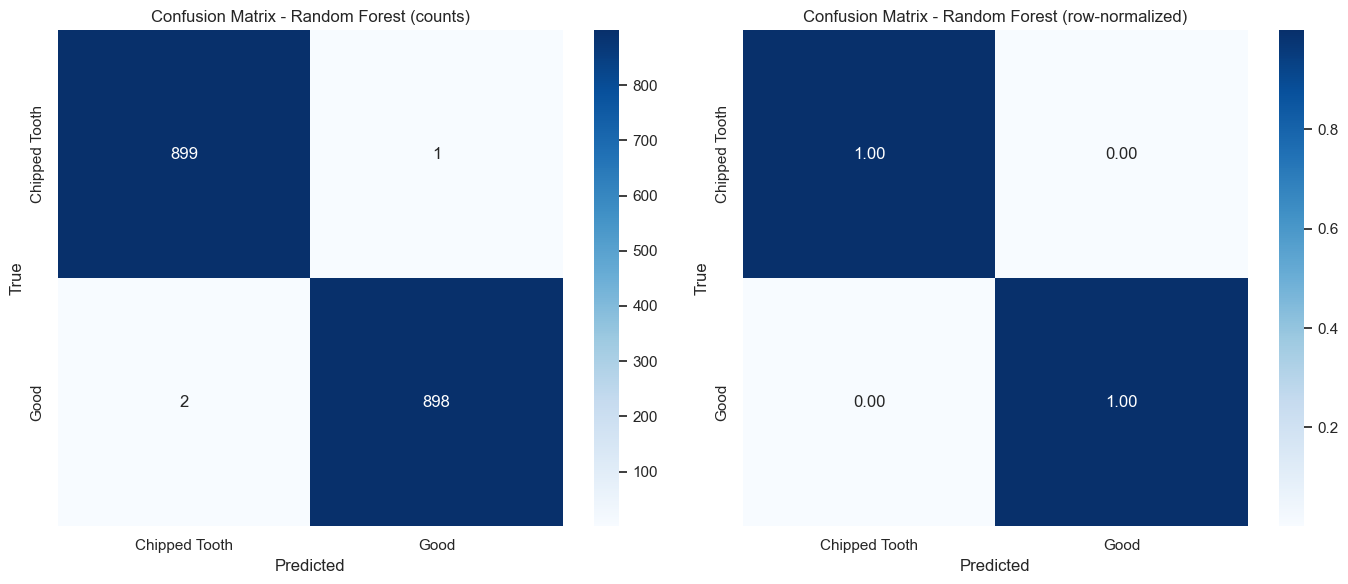

In [28]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix heatmaps for all classes (counts and row-normalized)
# Uses existing variables from the notebook if available: classes_all, y_test, y_pred_best, cm_all, cm_all_norm

import matplotlib.pyplot as plt

# determine class order
labels = sorted(np.unique(np.concatenate([np.asarray(y_test), np.asarray(y_pred_best)])))

# predictions (fallback to best_model if y_pred_best missing)
if 'y_pred_best' in globals() and np.asarray(y_pred_best).shape[0] == np.asarray(y_test).shape[0]:
    y_pred = np.asarray(y_pred_best)
else:
    # try to predict using best_model and X_test_scaled
    try:
        y_pred = best_model.predict(X_test_scaled)
    except Exception:
        raise RuntimeError("y_pred_best missing and best_model/X_test_scaled prediction failed.")

# confusion matrices (counts + row-normalized)
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Safe row normalization (avoid divide-by-zero)
row_sums = cm.sum(axis=1, keepdims=True).astype(float)
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = np.divide(cm, row_sums, where=row_sums != 0)
    cm_norm = np.nan_to_num(cm_norm)

# Plot heatmaps
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
axs[0].set_title(f'Confusion Matrix - {best_name} (counts)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_title(f'Confusion Matrix - {best_name} (row-normalized)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

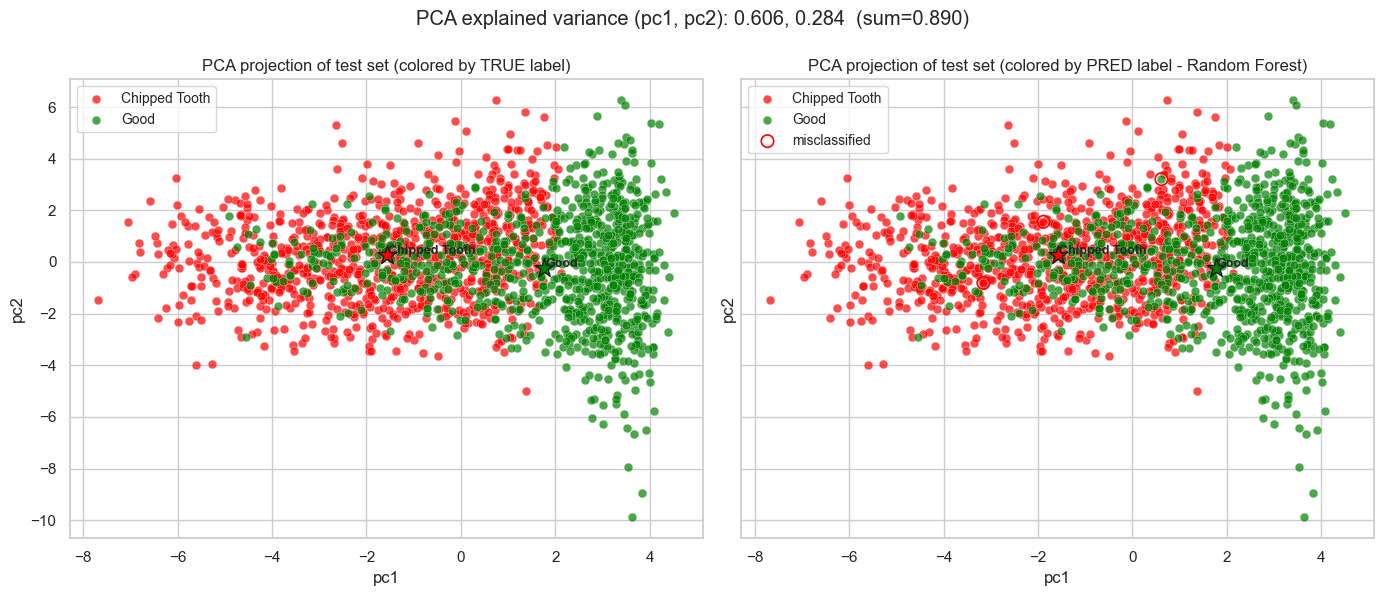

In [29]:
from sklearn.decomposition import PCA as _PCA
import warnings

# PCA-like 2D projection of the test set (unsupervised: PCA fit on train if available, otherwise on test)

# Suppress all warnings during PCA and plotting
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # use existing pca if present, otherwise create one
    pca = _PCA(n_components=2, random_state=42)

    # fit PCA on train (preferred) or on test if train not available
    if 'X_train_scaled' in globals() and getattr(X_train_scaled, "size", 0):
        pca.fit(X_train_scaled)
        proj = pca.transform(X_test_scaled)
    else:
        proj = pca.fit_transform(X_test_scaled)

    # build DataFrame for plotting
    df_proj = pd.DataFrame(proj, columns=['pc1', 'pc2'])
    df_proj['true'] = y_test
    df_proj['pred'] = y_pred_best

    # centroids per true class
    centroids = df_proj.groupby('true')[['pc1', 'pc2']].mean()

    # Create custom color mapping - "Good" is always green
    labels_plot = list(dict.fromkeys(list(best_model.classes_) + list(np.unique(y_test).tolist())))
    color_map = {}
    other_colors = ['red', 'orange', 'purple', 'brown', 'pink', 'cyan', 'magenta']
    other_idx = 0

    for lab in labels_plot:
        if str(lab).lower() in ['good', 'normal', 'healthy']:
            color_map[lab] = 'green'
        else:
            color_map[lab] = other_colors[other_idx % len(other_colors)]
            other_idx += 1

    # plot: left = colored by TRUE, right = colored by PRED (best model)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    for ax, col, title in zip(axs, ['true', 'pred'], ['PCA projection of test set (colored by TRUE label)', f'PCA projection of test set (colored by PRED label - {best_name})']):
        for lab in labels_plot:
            sel = df_proj[col] == lab
            if sel.any():
                ax.scatter(df_proj.loc[sel, 'pc1'], df_proj.loc[sel, 'pc2'], s=40, color=color_map[lab], label=lab, alpha=0.7, edgecolor='w', linewidth=0.3)
        # highlight misclassified points on the PRED plot
        if col == 'pred':
            mis = df_proj['true'] != df_proj['pred']
            if mis.any():
                ax.scatter(df_proj.loc[mis, 'pc1'], df_proj.loc[mis, 'pc2'], facecolors='none', edgecolors='red', s=80, linewidths=1.2, label='misclassified')
        # draw centroids
        for lab, row in centroids.iterrows():
            if lab in color_map:
                ax.scatter(row['pc1'], row['pc2'], marker='*', s=200, color=color_map[lab], edgecolor='k')
                ax.text(row['pc1'] + 0.02, row['pc2'] + 0.02, str(lab), fontsize=9, weight='bold')
        ax.set_title(title)
        ax.set_xlabel('pc1')
        ax.set_ylabel('pc2')
        ax.legend(loc='best', fontsize='small')

    explained = pca.explained_variance_ratio_
    plt.suptitle(f'PCA explained variance (pc1, pc2): {explained[0]:.3f}, {explained[1]:.3f}  (sum={explained[:2].sum():.3f})', y=0.99)
    plt.tight_layout()
    plt.show()

In [30]:
import os
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib



# Combine train + test data
y_all = np.concatenate([y_train, y_test])
X_all_raw = np.vstack([X_train, X_test]) if X_train.size or X_test.size else np.empty((0, X_train.shape[1]))

# Fit new scaler on full data and transform
deploy_scaler = StandardScaler()
X_all_scaled = deploy_scaler.fit_transform(X_all_raw)

# Recreate an unfitted model of the same class/config as best_model and fit on all data
model_cls = best_model.__class__
model_params = best_model.get_params()
deployed_model = model_cls(**model_params)
deployed_model.fit(X_all_scaled, y_all)



print(f"Deployed model trained on all data: {X_all_scaled.shape[0]} samples, {X_all_scaled.shape[1]} features")

Deployed model trained on all data: 9000 samples, 14 features


## 6) Batch prediction on new sample set

We will now run the best-performing model from this notebook on a separate set of unlabeled (or validation) samples located under `sample_data/audio/`.

Folder structure is expected as:
```
sample_data/audio/<label_name>/*.wav
```
Each folder name will be treated as the ground-truth class for evaluation. We will:
1. Discover all audio files.
2. Load + resample them with the shared loader (fixed 40 kHz).
3. Segment and extract features using the same parameters (`segment_seconds`, `overlap`, `feature_level`).
4. Predict per-segment and aggregate to a file-level prediction (mean probability or majority vote).
5. Produce a results DataFrame and overall accuracy (if labels are available via folder names).
6. Show a confusion matrix.


file     true_label  \
0  /Users/ibrahimelkhatib/Desktop/Fall2025/Predic...  Chipped Tooth   
1  /Users/ibrahimelkhatib/Desktop/Fall2025/Predic...  Chipped Tooth   
2  /Users/ibrahimelkhatib/Desktop/Fall2025/Predic...  Chipped Tooth   

      prediction  confidence  n_segments  n_features_extracted  
0  Chipped Tooth      0.9841         100                    14  
1  Chipped Tooth      0.9920          25                    14  
2  Chipped Tooth      0.9808          75                    14

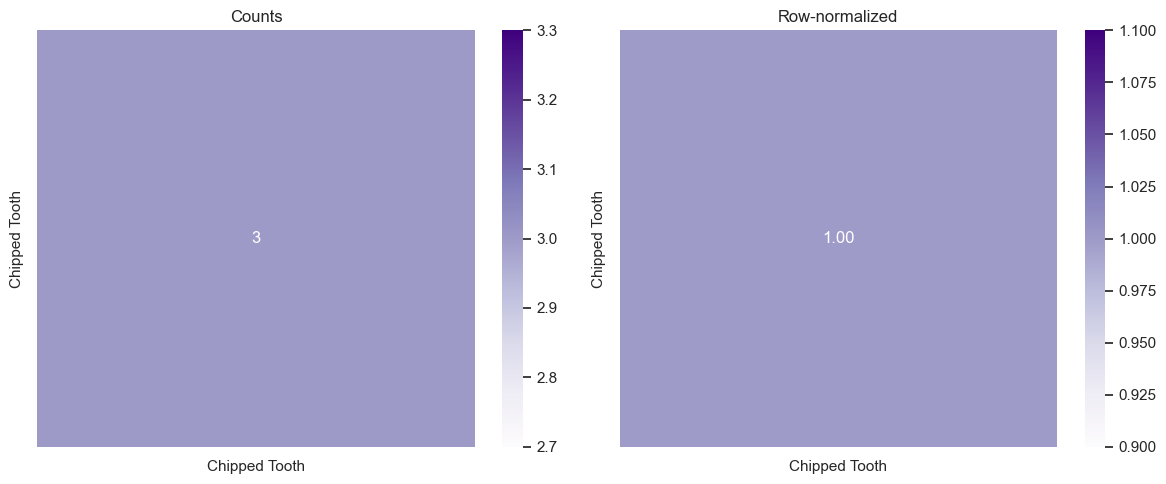

In [31]:
# Batch prediction UI using external helper script (isolated import of batch_predict only)
from pathlib import Path
import importlib.util

# Dynamically load batch_predict WITHOUT adding the whole Models directory to sys.path
_bp_path = Path('Preparation/Sample Preparation/Models/batch_predict.py').resolve()
if not _bp_path.exists():
    raise FileNotFoundError(f'Cannot locate batch_predict.py at {_bp_path}')
_spec = importlib.util.spec_from_file_location('batch_predict_ui', str(_bp_path))
_bp_mod = importlib.util.module_from_spec(_spec)
_spec.loader.exec_module(_bp_mod)  # type: ignore[attr-defined]
render_batch_prediction_ui = getattr(_bp_mod, 'render_batch_prediction_ui')



# Only the in-notebook trained best_model is used for inference below.
ui_batch = render_batch_prediction_ui(
    best_model=deployed_model,
    scaler=scaler,
    segment_seconds=segment_seconds,
    overlap=overlap,
    feature_level=feature_level,
    train_feat_names=feat_names if 'feat_names' in globals() else None,
    sample_root=Path('sample_data/audio'),
)
ui_batch

## 7) Live Audio Inspection - Continuous Monitoring

This section demonstrates deploying the trained model for real-time continuous inspection. In industrial scenarios, this would be used to monitor machinery continuously and alert operators to potential faults as they develop.

We'll implement two approaches:
1. **Real-time live audio capture** - Stream audio from a microphone/sensor in real-time
2. **File-based simulation** - Simulate streaming by reading from an existing audio file

This simulates how the trained model would be deployed in production for continuous predictive maintenance monitoring.

In [32]:
# Import the live inspection module
from pathlib import Path
import importlib.util
import numpy as np
import pandas as pd
import time

# Dynamically load live_inspector module
_li_path = Path('Preparation/Sample Preparation/Models/live_inspector.py').resolve()
if not _li_path.exists():
    raise FileNotFoundError(f'Cannot locate live_inspector.py at {_li_path}')
    
_spec = importlib.util.spec_from_file_location('live_inspector', str(_li_path))
_li_mod = importlib.util.module_from_spec(_spec)
_spec.loader.exec_module(_li_mod)

# Import classes and functions
LiveAudioInspector = _li_mod.LiveAudioInspector
create_live_inspector_ui = _li_mod.create_live_inspector_ui
simulate_streaming_from_file = _li_mod.simulate_streaming_from_file

print("Live inspection module loaded successfully!")

Live inspection module loaded successfully!


In [33]:
# List available audio devices first
import sounddevice as sd

print("Available audio input devices:")
devices = sd.query_devices()
for i, device in enumerate(devices):
    if device['max_input_channels'] > 0:
        print(f"  {i}: {device['name']} ({device['max_input_channels']} ch, {device['default_samplerate']} Hz)")

print(f"\\nDefault input device: {sd.default.device[0] if hasattr(sd.default, 'device') else 'None'}")
print("\\nTo use a specific device, modify the 'device' parameter when creating the inspector.")

Available audio input devices:
  0: Ibrahim’s iPhone Microphone (1 ch, 48000.0 Hz)
  1: MacBook Pro Microphone (1 ch, 44100.0 Hz)
  3: Immersed (2 ch, 48000.0 Hz)
\nDefault input device: 1
\nTo use a specific device, modify the 'device' parameter when creating the inspector.


In [34]:
# Configure the live inspector with our trained model
# Ensure we have the required variables from training
if 'best_model' not in globals() or 'scaler' not in globals():
    raise RuntimeError('Please run the training section first to create best_model and scaler')

# Create live inspector instance
inspector = LiveAudioInspector(
    model=deployed_model,
    scaler=scaler,
    segment_seconds=segment_seconds,  # Analyze 2-second segments
    overlap=overlap,          # 50% overlap between segments
    feature_level=feature_level,  # Use same feature level as training
    feature_names=feature_names,     # Expected feature names from training
    buffer_duration=10.0,         # Keep 10 seconds of audio in buffer
    device=None                  # Use default microphone (change if needed)
)

print(f"Live inspector configured:")
print(f"  Model: {best_name}")
print(f"  Feature level: {feature_level}")
print(f"  Segment duration: {segment_seconds}s with {overlap*100}% overlap")
print(f"  Expected features: {len(feature_names) if feature_names else 'Unknown'}")
print(f"  Model classes: {list(deployed_model.classes_)}")
print("\\nReady for live inspection!")

Live inspector configured:
  Model: Random Forest
  Feature level: basic
  Segment duration: 0.2s with 0% overlap
  Expected features: Unknown
  Model classes: [np.str_('Chipped Tooth'), np.str_('Good')]
\nReady for live inspection!


### Option 1: Real-Time Live Audio Capture

This creates an interactive UI for real-time audio monitoring. When you click "Start Inspection", the system will:

1. Start capturing audio from your microphone/audio interface
2. Continuously analyze 2-second segments with 50% overlap  
3. Extract the same features used during training
4. Make predictions using the trained model
5. Display results in real-time with confidence scores
6. Plot prediction timeline and confidence trends

**Note:** Make sure your audio device is connected and accessible before starting.

In [ ]:
# Import and display the Enhanced Live Inspector UI
# Use a dynamic file-based import so the notebook doesn't require the module to be on sys.path
from pathlib import Path
import importlib.util
from IPython.display import display

_ui_path = Path('Preparation/Sample Preparation/Models/enhanced_live_inspector_ui.py').resolve()
_spec = importlib.util.spec_from_file_location('enhanced_live_inspector_ui', str(_ui_path))
_ui_mod = importlib.util.module_from_spec(_spec)
_spec.loader.exec_module(_ui_mod)  # type: ignore[attr-defined]
create_enhanced_live_inspector_ui = getattr(_ui_mod, 'create_enhanced_live_inspector_ui')

# Create and display the enhanced UI
if 'inspector' in globals():
    enhanced_ui = create_enhanced_live_inspector_ui(inspector)
    display(enhanced_ui)
    print("✅ Enhanced Live Inspector UI loaded successfully!")
    print("📁 UI code is now organized in: enhanced_live_inspector_ui.py")
else:
    print("❌ Inspector not found. Please run the inspector configuration cell first.")

✅ Enhanced Live Inspector UI loaded successfully!
📁 UI code is now organized in: enhanced_live_inspector_ui.py


## 🎉 Enhanced Live Inspector Features - COMPLETE & ORGANIZED!

### ✅ **New Features Successfully Implemented:**

#### 1. **🔄 Continuous Graph Updates**
- **Real-time plotting**: Graphs now update automatically every 2 seconds during monitoring
- **No more waiting**: You can see live changes without stopping the system
- **Performance optimized**: Updates run in background thread without blocking the UI

#### 2. **💾 Advanced CSV Data Logging**
- **Comprehensive data**: Saves machine_id, timestamp, prediction, confidence, threshold_used, model_used, feature_level, session_start
- **Auto-save functionality**: Configurable intervals from 10-300 seconds
- **Manual save option**: "SAVE DATA" button available anytime during operation
- **Final save**: Automatic save when stopping monitoring
- **Timestamped files**: `machine_monitoring_{machine_id}_{timestamp}_{type}.csv`

#### 3. **🏭 Machine Number Identification**
- **Machine ID input**: Text field for unique machine identification
- **Multi-machine support**: Perfect for class activities with multiple machines
- **Included in all data**: Machine ID appears in CSV files and graph titles
- **Default naming**: Starts with "Machine_001" but fully customizable

### ?️ **Clean Code Organization:**

The enhanced UI code has been moved to a separate, well-documented module:
- **📁 File**: `enhanced_live_inspector_ui.py`
- **📚 Documentation**: Comprehensive docstrings and comments
- **🔧 Modular**: Easy to import and use
- **🎯 Clean notebook**: No more 500+ lines of UI code cluttering the analysis

### ?🚀 **How to Use the Enhanced Features:**

1. **Setup**:
   - Enter your unique Machine ID (e.g., "Machine_001", "Machine_A", "Student_Team_1")
   - Configure auto-save interval (recommended: 30 seconds for class activities)
   - Set confidence threshold as needed

2. **Operation**:
   - Click "START MONITORING" - graphs will begin updating automatically every 2 seconds
   - Watch real-time changes in both the prediction timeline and confidence trend plots
   - Data is automatically saved at your configured interval
   - Use "SAVE DATA" button for manual saves anytime

3. **Data Collection**:
   - CSV files include full metadata for analysis
   - Perfect for comparing multiple machines in class
   - Easy to import into spreadsheets or analysis tools



The enhanced system maintains all original functionality while adding these powerful new features for educational and professional use!